In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import Input

In [2]:
df = pd.read_csv('./data/df_final.csv')

In [3]:
df.head()

,STATION,PRCP,TMAX,TMIN,Year,County,Yield(Unit/Acre)
0,USC00048351,0.0,NaN,NaN,1980,Sonoma,3.34
1,USC00048351,0.0,53.0,38.0,1981,Sonoma,3.39
2,USC00048351,0.5,51.0,35.0,1982,Sonoma,4.00
3,USC00048351,0.0,48.0,32.0,1983,Sonoma,3.14
4,USC00048351,0.0,63.0,36.0,1984,Sonoma,3.81


In [4]:
df.isna().sum()

STATION              0
PRCP                26
TMAX                52
TMIN                55
Year                 0
County               0
Yield(Unit/Acre)     0
dtype: int64

In [5]:
df['PRCP'] = df['PRCP'].transform(lambda x: x.fillna(x.median()))
df['TMIN'] = df['TMIN'].transform(lambda x: x.fillna(x.median()))
df['TMAX'] = df['TMAX'].transform(lambda x: x.fillna(x.median()))

In [6]:
df.isna().sum()

STATION             0
PRCP                0
TMAX                0
TMIN                0
Year                0
County              0
Yield(Unit/Acre)    0
dtype: int64

<Axes: xlabel='Year', ylabel='PRCP'>

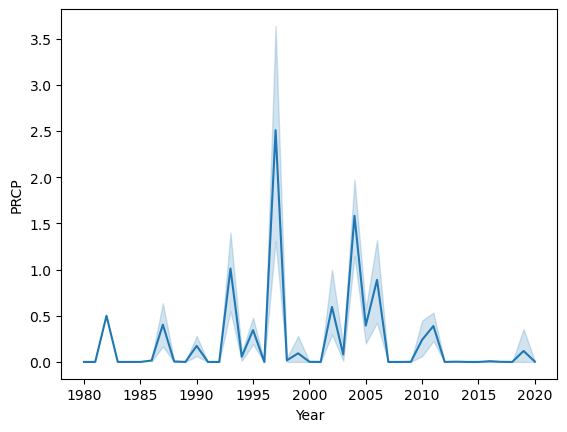

In [7]:
sns.lineplot(data=df, x='Year', y='PRCP')

<Axes: xlabel='Year', ylabel='TMIN'>

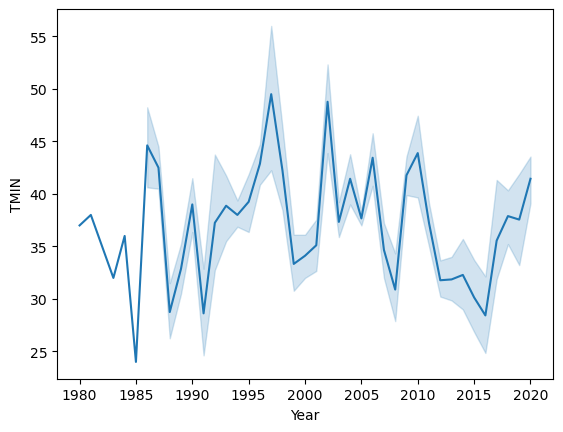

In [8]:
sns.lineplot(data=df, x='Year', y='TMIN')

<Axes: xlabel='Year', ylabel='TMAX'>

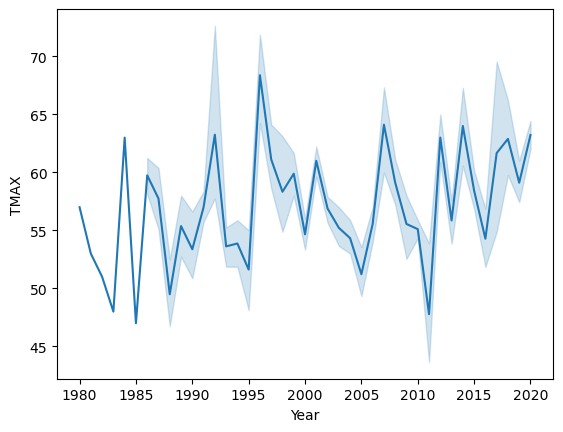

In [9]:
sns.lineplot(data=df, x='Year', y='TMAX')

<Axes: xlabel='Year', ylabel='Yield(Unit/Acre)'>

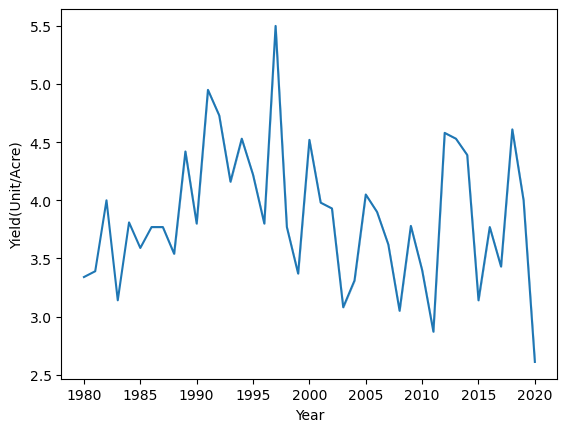

In [10]:
sns.lineplot(data=df, x='Year', y='Yield(Unit/Acre)')

In [11]:
# only drop a column that won't have an impact on my selection
df = df.drop(['County'], axis=1)

In [12]:
stations = df.STATION.unique()
print(len(stations))
print(stations)

9
['USC00048351' 'USC00047965' 'USC00043578' 'USC00043875' 'USC00046370'
 'USC00046826' 'USC00043191' 'USC00041838' 'USW00023213']


In [13]:
df['STATION'] = df['STATION'].str.slice(6, 11)

In [14]:
df['STATION'] = df['STATION'].astype(int)

In [15]:
df.dtypes

STATION               int64
PRCP                float64
TMAX                float64
TMIN                float64
Year                  int64
Yield(Unit/Acre)    float64
dtype: object

In [16]:
df.head()

,STATION,PRCP,TMAX,TMIN,Year,Yield(Unit/Acre)
0,48351,0.0,57.0,37.0,1980,3.34
1,48351,0.0,53.0,38.0,1981,3.39
2,48351,0.5,51.0,35.0,1982,4.00
3,48351,0.0,48.0,32.0,1983,3.14
4,48351,0.0,63.0,36.0,1984,3.81


In [17]:
X = df.drop(['Yield(Unit/Acre)'], axis = 1)
y = df['Yield(Unit/Acre)']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

In [19]:
# steps is how many times I want my model to train. Maybe 10, maybe 20 - how many times the model cycles through
# The model learns every step - it is cumulative 
n_steps = 1

# The models knows the features based on the columns
n_features = 3

# for units (?)
print(X_train.shape, y_train.shape)
print(n_steps, n_features)

(225, 5) (225,)
1 3


In [20]:
# https://keras.io/api/models/model_training_apis/
model = Sequential()
model.add(Input(shape=(n_steps, n_features))) 
model.add(LSTM(225))
model.add(Dense(1))
# https://faroit.com/keras-docs/1.1.0/optimizers/
model.compile(optimizer='sgd', loss='mse')

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 225)            │       206,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           226 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,326 (805.96 KB)

 Trainable params: 206,326 (805.96 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.fit(X_train, y_train, epochs=10, verbose=2)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 5), dtype=float32). Expected shape (None, 1, 3), but input has incompatible shape (None, 5)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 5), dtype=float32)
  • training=True
  • mask=None

In [249]:
# model.predict(X_test)